In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jessicali9530/celeba-dataset'
od.download(dataset_url)

  1%|          | 7.00M/1.33G [00:00<00:19, 72.1MB/s]

100%|██████████| 1.33G/1.33G [00:12<00:00, 115MB/s]


In [5]:
import os

DATA_DIR = './celeba-dataset/img_align_celeba'
print(os.listdir(DATA_DIR))

['img_align_celeba']


In [6]:
print(os.listdir(DATA_DIR+'/img_align_celeba')[:10])

['170960.jpg', '168850.jpg', '197010.jpg', '097776.jpg', '154471.jpg', '175948.jpg', '079475.jpg', '091507.jpg', '064099.jpg', '157968.jpg']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


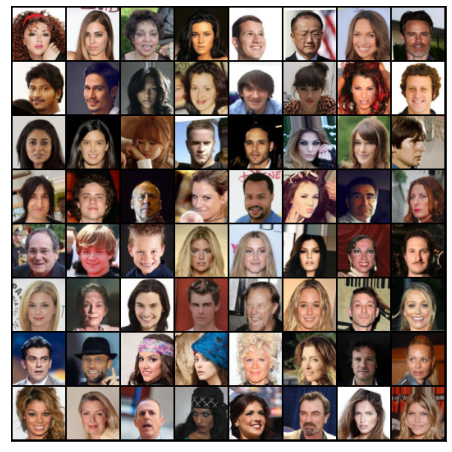

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)

In [17]:
import torch.nn as nn

In [18]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [19]:
discriminator = to_device(discriminator, device)

In [24]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [25]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [26]:
from torchvision.utils import save_image

In [27]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [29]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


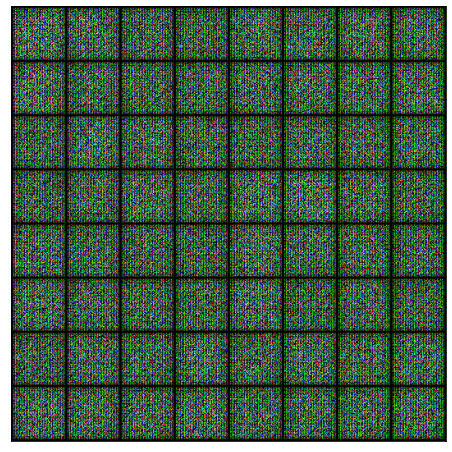

In [30]:
save_samples(0, fixed_latent)

In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [33]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [34]:
lr = 0.0002
epochs = 50

In [35]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/50], loss_g: 4.3296, loss_d: 0.4078, real_score: 0.9637, fake_score: 0.2848
Saving generated-images-0001.png



Epoch [2/50], loss_g: 3.0751, loss_d: 0.3094, real_score: 0.8409, fake_score: 0.1092
Saving generated-images-0002.png



Epoch [3/50], loss_g: 3.4183, loss_d: 0.2192, real_score: 0.9061, fake_score: 0.1040
Saving generated-images-0003.png



Epoch [4/50], loss_g: 2.3108, loss_d: 0.6801, real_score: 0.5691, fake_score: 0.0058
Saving generated-images-0004.png



Epoch [5/50], loss_g: 3.4582, loss_d: 0.2036, real_score: 0.8988, fake_score: 0.0804
Saving generated-images-0005.png



Epoch [6/50], loss_g: 4.6398, loss_d: 0.1637, real_score: 0.8826, fake_score: 0.0230
Saving generated-images-0006.png



Epoch [7/50], loss_g: 4.4420, loss_d: 0.1206, real_score: 0.9288, fake_score: 0.0399
Saving generated-images-0007.png



Epoch [8/50], loss_g: 4.8545, loss_d: 0.1577, real_score: 0.8719, fake_score: 0.0092
Saving generated-images-0008.png



Epoch [9/50], loss_g: 5.5282, loss_d: 0.0985, real_score: 0.9259, fake_score: 0.0130
Saving generated-images-0009.png



Epoch [10/50], loss_g: 5.0067, loss_d: 0.0346, real_score: 0.9916, fake_score: 0.0251
Saving generated-images-0010.png



Epoch [11/50], loss_g: 4.4295, loss_d: 0.0670, real_score: 0.9946, fake_score: 0.0553
Saving generated-images-0011.png



Epoch [12/50], loss_g: 5.1682, loss_d: 0.0765, real_score: 0.9817, fake_score: 0.0530
Saving generated-images-0012.png



Epoch [13/50], loss_g: 4.7668, loss_d: 0.1052, real_score: 0.9386, fake_score: 0.0305
Saving generated-images-0013.png



Epoch [14/50], loss_g: 5.0532, loss_d: 0.1124, real_score: 0.9885, fake_score: 0.0862
Saving generated-images-0014.png



Epoch [15/50], loss_g: 6.6620, loss_d: 0.0231, real_score: 0.9943, fake_score: 0.0109
Saving generated-images-0015.png



Epoch [16/50], loss_g: 5.2707, loss_d: 0.0418, real_score: 0.9799, fake_score: 0.0201
Saving generated-images-0016.png



Epoch [17/50], loss_g: 5.3388, loss_d: 0.0953, real_score: 0.9935, fake_score: 0.0771
Saving generated-images-0017.png



Epoch [18/50], loss_g: 4.3565, loss_d: 0.0716, real_score: 0.9439, fake_score: 0.0085
Saving generated-images-0018.png



Epoch [19/50], loss_g: 4.9148, loss_d: 0.0776, real_score: 0.9771, fake_score: 0.0489
Saving generated-images-0019.png



Epoch [20/50], loss_g: 5.7849, loss_d: 0.0568, real_score: 0.9566, fake_score: 0.0082
Saving generated-images-0020.png



Epoch [21/50], loss_g: 4.4017, loss_d: 0.0490, real_score: 0.9647, fake_score: 0.0091
Saving generated-images-0021.png



Epoch [22/50], loss_g: 4.9818, loss_d: 0.0709, real_score: 0.9882, fake_score: 0.0521
Saving generated-images-0022.png



Epoch [23/50], loss_g: 7.3494, loss_d: 0.2795, real_score: 0.9952, fake_score: 0.1817
Saving generated-images-0023.png



Epoch [24/50], loss_g: 0.9189, loss_d: 0.5022, real_score: 0.7338, fake_score: 0.0377
Saving generated-images-0024.png



Epoch [25/50], loss_g: 5.8890, loss_d: 0.0490, real_score: 0.9812, fake_score: 0.0280
Saving generated-images-0025.png



Epoch [26/50], loss_g: 5.0754, loss_d: 0.0827, real_score: 0.9474, fake_score: 0.0197
Saving generated-images-0026.png



Epoch [27/50], loss_g: 7.7547, loss_d: 0.0528, real_score: 0.9624, fake_score: 0.0068
Saving generated-images-0027.png



Epoch [28/50], loss_g: 5.2656, loss_d: 0.0997, real_score: 0.9540, fake_score: 0.0389
Saving generated-images-0028.png



Epoch [29/50], loss_g: 5.9364, loss_d: 0.0308, real_score: 0.9880, fake_score: 0.0179
Saving generated-images-0029.png



Epoch [30/50], loss_g: 3.6228, loss_d: 0.1845, real_score: 0.8863, fake_score: 0.0427
Saving generated-images-0030.png



Epoch [31/50], loss_g: 5.4426, loss_d: 0.0862, real_score: 0.9814, fake_score: 0.0599
Saving generated-images-0031.png



Epoch [32/50], loss_g: 5.8067, loss_d: 0.0391, real_score: 0.9865, fake_score: 0.0239
Saving generated-images-0032.png



Epoch [33/50], loss_g: 6.0341, loss_d: 0.0436, real_score: 0.9726, fake_score: 0.0143
Saving generated-images-0033.png



Epoch [34/50], loss_g: 1.9602, loss_d: 0.5216, real_score: 0.7188, fake_score: 0.0338
Saving generated-images-0034.png



Epoch [35/50], loss_g: 7.3521, loss_d: 0.1281, real_score: 0.9952, fake_score: 0.0882
Saving generated-images-0035.png



Epoch [36/50], loss_g: 3.4710, loss_d: 0.0783, real_score: 0.9964, fake_score: 0.0639
Saving generated-images-0036.png



Epoch [37/50], loss_g: 3.7054, loss_d: 0.1347, real_score: 0.9477, fake_score: 0.0565
Saving generated-images-0037.png



Epoch [38/50], loss_g: 5.7716, loss_d: 0.0522, real_score: 0.9931, fake_score: 0.0363
Saving generated-images-0038.png



Epoch [39/50], loss_g: 6.8560, loss_d: 0.0453, real_score: 0.9657, fake_score: 0.0066
Saving generated-images-0039.png



Epoch [40/50], loss_g: 3.9713, loss_d: 0.1000, real_score: 0.9358, fake_score: 0.0267
Saving generated-images-0040.png



Epoch [41/50], loss_g: 7.1345, loss_d: 0.0097, real_score: 0.9948, fake_score: 0.0043
Saving generated-images-0041.png



Epoch [42/50], loss_g: 5.3928, loss_d: 0.1012, real_score: 0.9494, fake_score: 0.0406
Saving generated-images-0042.png



Epoch [43/50], loss_g: 5.8824, loss_d: 0.0686, real_score: 0.9780, fake_score: 0.0401
Saving generated-images-0043.png



Epoch [44/50], loss_g: 4.6423, loss_d: 0.0824, real_score: 0.9493, fake_score: 0.0136
Saving generated-images-0044.png



Epoch [45/50], loss_g: 5.1485, loss_d: 0.0370, real_score: 0.9906, fake_score: 0.0254
Saving generated-images-0045.png



Epoch [46/50], loss_g: 5.7898, loss_d: 0.0606, real_score: 0.9987, fake_score: 0.0520
Saving generated-images-0046.png



Epoch [47/50], loss_g: 4.3668, loss_d: 0.1081, real_score: 0.9430, fake_score: 0.0310
Saving generated-images-0047.png



Epoch [48/50], loss_g: 5.9382, loss_d: 0.0216, real_score: 0.9944, fake_score: 0.0145
Saving generated-images-0048.png



Epoch [49/50], loss_g: 5.3161, loss_d: 0.0396, real_score: 0.9839, fake_score: 0.0200
Saving generated-images-0049.png



Epoch [50/50], loss_g: 5.7251, loss_d: 0.0596, real_score: 0.9679, fake_score: 0.0198
Saving generated-images-0050.png


In [ ]:
history += fit(20, 0.0005)

In [36]:
losses_g, losses_d, real_scores, fake_scores = history

In [37]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [38]:
from IPython.display import Image

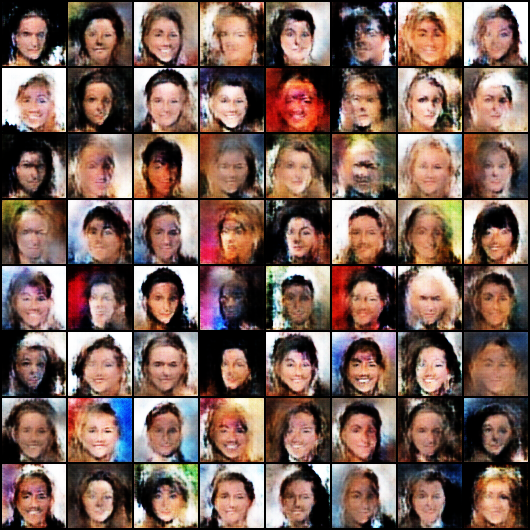

In [39]:
Image('./generated/generated-images-0001.png')

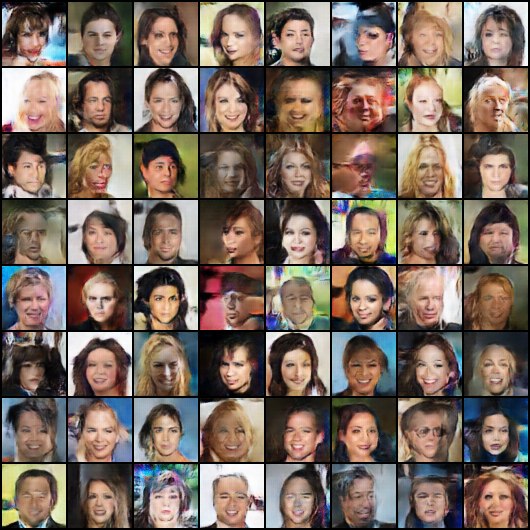

In [40]:
Image('./generated/generated-images-0005.png')

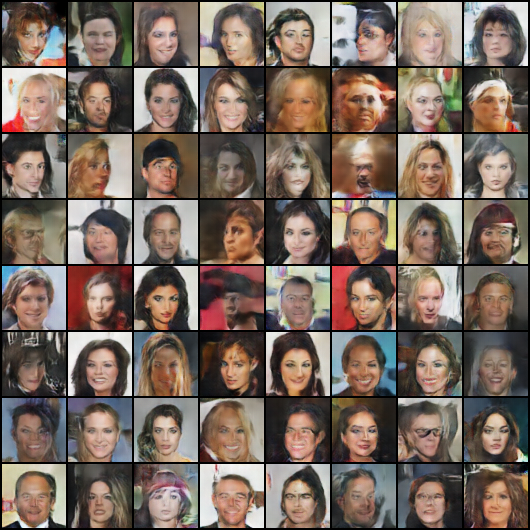

In [41]:
Image('./generated/generated-images-0010.png')

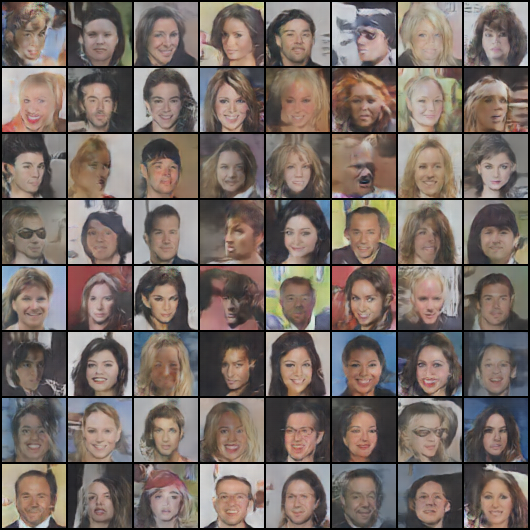

In [42]:
Image('./generated/generated-images-0020.png')

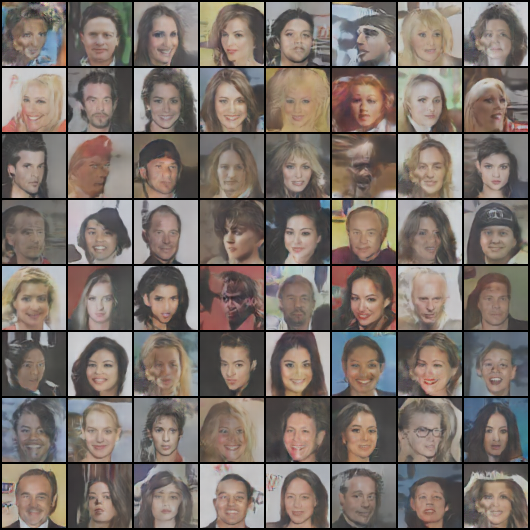

In [47]:
Image('./generated/generated-images-0050.png')

In [44]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

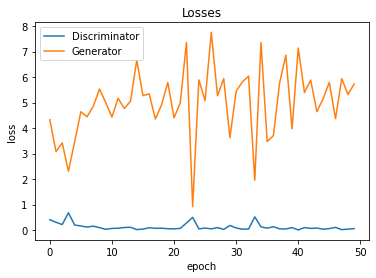

In [45]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

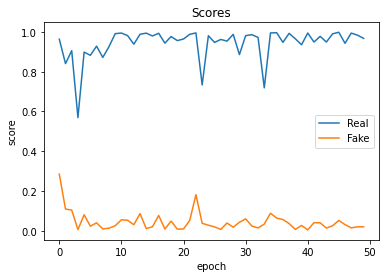

In [46]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');